In [ ]:
!pip install --upgrade openai

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from collections import Counter
import pprint
import joblib
import time
import re
import json
from pathlib import Path
import requests
import json

from tqdm.notebook import trange

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

from nltk.tokenize import word_tokenize

from sklearn.metrics import classification_report, accuracy_score

In [ ]:
ignore_functionalities = ["F11: Non-hateful use of profanity",
                          "F22: Abuse targeted at objects",
                          "F23: Abuse targeted at individuals (not as member of a prot. group)",
                          "F24: Abuse targeted at nonprotected groups (e.g. professions)",
                          "F25-29: Spelling variation"]

In [ ]:
env = "colab"  # "local" or "colab"
if env == "colab":
    ROOT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/biases-hatecheck/")
elif env == "local":
    ROOT_DIR = Path("/Users/admin/upf-projects/biases-hatecheck/")
with open(ROOT_DIR/"openai-secret.txt", "r") as f:
  API_KEY = f.read().strip()

In [ ]:
url = "https://api.openai.com/v1/moderations"

headers = {"Content-Type": "application/json; charset=utf-8",
           "Authorization": f"Bearer {API_KEY}"}

max_tries = 3

def pred_w_moderation(messages, target_identity=None):
  pred = None
  attempt = 0

  if type(messages) == str:
    messages = [messages]

  data = {
    "input": messages,
    "model": "text-moderation-latest"
  }

  while attempt < max_tries:
    try:
      response = requests.post(url, headers=headers, json=data)

      #print("Status Code", response.status_code)
      results = response.json()['results']
      flagged, scores = [], []
      for result in results:
        flagged.append(result['flagged'])
        category_scores = result['category_scores']
        max_score = -1
        for category, score in category_scores.items():
          if not category.startswith("self-harm") and score > max_score:
            max_score = score
        scores.append(max_score)
      return {"flagged": flagged, "scores": scores}
    except Exception as e:
      print(e)
    attempt += 1
  return pred

## 0. HelloWorld example

In [ ]:
message = "I wish all gays are as normal as us."
safe_message = "I'm better dead than alive."

pred = pred_w_moderation([message, safe_message])
pred

Status Code 200


{'flagged': [True, False],
 'scores': [0.7840215563774109, 0.020528852939605713]}

## 1. Load GPT-HateCheckDataset and Predict

The prediction files are written to /datasets/GPT-HateCheck/gpt-4o/

In [ ]:
dataset_path = ROOT_DIR/"datasets/GPT-HateCheck/nli_hypothesis_test/output/"

In [ ]:
a = list(range(20))
for i in trange(0, len(a), 4):
  print(a[i:i+4])

  0%|          | 0/5 [00:00<?, ?it/s]

[0, 1, 2, 3]
[4, 5, 6, 7]
[8, 9, 10, 11]
[12, 13, 14, 15]
[16, 17, 18, 19]


In [ ]:
bs = 20
for p in dataset_path.glob('**/*.csv'):
  if (ROOT_DIR/"datasets/GPT-HateCheck/openai_moderation/"/p.name).is_file():
    print(f"[WARNING] File perspective-{p.name} already exists. Skipped.")
    continue
  target_identity =  re.search('dataset_(.+?).csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[df['nli_pass_test']==1]
  df = df[~df['functionality'].isin(ignore_functionalities)]
  messages = df['message'].tolist()
  functionalities = df['functionality'].tolist()
  hate_labels = df['hate_label'].tolist()
  n_messages = len(messages)
  preds = []
  print(f"Predicting for file: {p.name} with {n_messages} messages.")
  for i in trange(0, n_messages, bs):
    pred = pred_w_moderation(messages[i:i+bs], target_identity)
    preds.extend(pred['scores'])

  df_out = pd.DataFrame({"message": messages,
                         "functionality":  functionalities,
                         "hate_label": hate_labels,
                         "pred_score": preds,
                        })
  df_out.to_csv(ROOT_DIR/"datasets/GPT-HateCheck/openai_moderation/"/p.name, index=False)

### 1.1 Evaluation and analysis

In [ ]:
pred_path = ROOT_DIR/"datasets/GPT-HateCheck/openai_moderation/"

In [ ]:
# Overall accuracy
for p in pred_path.glob('**/*.csv'):
  target_identity = re.search('dataset_(.+?).csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[~df['functionality'].isin(ignore_functionalities)]
  df['toxicity_pred'] = df.apply(lambda x: int(x['pred_score']>0.5), axis=1)
  toxicity_acc = accuracy_score(y_true=df['hate_label'].tolist(), y_pred=df['toxicity_pred'].tolist())
  print(f"Target identity: {target_identity}")
  print(f"acc: {toxicity_acc:.4f}")

Target identity: black people
toxicity_acc: 0.8456
Target identity: Muslims
toxicity_acc: 0.9522
Target identity: disabled people
toxicity_acc: 0.9662
Target identity: trans
toxicity_acc: 0.9452
Target identity: women
toxicity_acc: 0.9538
Target identity: gays
toxicity_acc: 0.9556
Target identity: immigrants
toxicity_acc: 0.9319


In [ ]:
# Averaged functionality-level accuracy
for target_identity,df in dfs.items():
  df = df[~df['functionality'].isin(ignore_functionalities)]
  df['toxicity_pred'] = df.apply(lambda x: int(x['pred_score_mean']>0.5), axis=1)
  df['is_correct'] = df.apply(lambda x: 1 if x['toxicity_pred']==x['hate_label'] else 0, axis=1)
  df_func_acc = df[['functionality', 'hate_label', 'is_correct']].groupby('functionality').mean().reset_index()
  overall_acc = df_func_acc['is_correct'].mean()
  df_category_acc = df_func_acc[['hate_label', 'is_correct']].groupby('hate_label').mean().reset_index().sort_values('hate_label', ascending=False)
  cat_acc = df_category_acc['is_correct'].tolist()
  print(f"Target identity: {target_identity}")
  print(f"Overall acc: {overall_acc:.3f}; Hateful subset acc: {cat_acc[0]:.3f}; Non-hateful subset acc: {cat_acc[1]:.3f}")

Target identity: gays
Overall acc: 0.966; Hateful subset acc: 0.998; Non-hateful subset acc: 0.907
Target identity: black people
Overall acc: 0.964; Hateful subset acc: 1.000; Non-hateful subset acc: 0.922
Target identity: disabled people
Overall acc: 0.967; Hateful subset acc: 0.998; Non-hateful subset acc: 0.909
Target identity: trans
Overall acc: 0.986; Hateful subset acc: 0.991; Non-hateful subset acc: 0.978
Target identity: women
Overall acc: 0.982; Hateful subset acc: 0.992; Non-hateful subset acc: 0.962
Target identity: immigrants
Overall acc: 0.917; Hateful subset acc: 0.949; Non-hateful subset acc: 0.857
Target identity: Muslims
Overall acc: 0.959; Hateful subset acc: 0.998; Non-hateful subset acc: 0.888


In [ ]:
# Averaged functionality-level prediction
for target_identity,df in dfs.items():
  df = df[~df['functionality'].isin(ignore_functionalities)]
  df_func_acc = df[['functionality', 'hate_label', 'pred_score_mean']].groupby('functionality').mean().reset_index()
  overall_pred = df_func_acc['pred_score_mean'].mean()
  df_category_acc = df_func_acc[['hate_label', 'pred_score_mean']].groupby('hate_label').mean().reset_index().sort_values('hate_label', ascending=False)
  cat_pred = df_category_acc['pred_score_mean'].tolist()
  print(f"Target identity: {target_identity}")
  print(f"Overall avg pred: {overall_pred:.3f}; Hateful subset avg pred: {cat_pred[0]:.3f}; Non-hateful subset avg pred: {cat_pred[1]:.3f}")

Target identity: gays
Overall avg pred: 0.643; Hateful subset avg pred: 0.937; Non-hateful subset avg pred: 0.096
Target identity: black people
Overall avg pred: 0.553; Hateful subset avg pred: 0.953; Non-hateful subset avg pred: 0.080
Target identity: disabled people
Overall avg pred: 0.649; Hateful subset avg pred: 0.946; Non-hateful subset avg pred: 0.096
Target identity: trans
Overall avg pred: 0.608; Hateful subset avg pred: 0.918; Non-hateful subset avg pred: 0.032
Target identity: women
Overall avg pred: 0.643; Hateful subset avg pred: 0.911; Non-hateful subset avg pred: 0.060
Target identity: immigrants
Overall avg pred: 0.587; Hateful subset avg pred: 0.841; Non-hateful subset avg pred: 0.115
Target identity: Muslims
Overall avg pred: 0.646; Hateful subset avg pred: 0.935; Non-hateful subset avg pred: 0.108


In [ ]:
for p in pred_path.glob('**/*.csv'):
  target_identity = re.search('dataset_(.+?).csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[~df['functionality'].isin(ignore_functionalities)]
  df['toxicity_pred'] = df.apply(lambda x: int(x['pred_score']>0.5), axis=1)
  identity_attack_report = classification_report(y_true=df['hate_label'].tolist(), y_pred=df['toxicity_pred'].tolist(), digits=3)
  print(f"Target identity: {target_identity}")
  print(identity_attack_report)

Target identity: black people
              precision    recall  f1-score   support

           0      0.949     0.690     0.799       374
           1      0.796     0.970     0.875       468

    accuracy                          0.846       842
   macro avg      0.873     0.830     0.837       842
weighted avg      0.864     0.846     0.841       842

Target identity: Muslims
              precision    recall  f1-score   support

           0      0.930     0.911     0.920       190
           1      0.962     0.970     0.966       438

    accuracy                          0.952       628
   macro avg      0.946     0.940     0.943       628
weighted avg      0.952     0.952     0.952       628

Target identity: disabled people
              precision    recall  f1-score   support

           0      0.963     0.942     0.953       224
           1      0.968     0.980     0.974       397

    accuracy                          0.966       621
   macro avg      0.966     0.961     0.

## 2. Bias analysis
### 2.2 Minimum set analysis

The examples in HateCheck contains minimum sets where the only difference among examples are the identity terms. Therefore, we can calculate the diviation of predictions among mimimum sets.

Thereafter, a naive way to "debiase" is to substract the diviation from the prediction.

In [ ]:
dataset_path = ROOT_DIR/"datasets/HateCheck/"

In [ ]:
df = pd.read_csv(dataset_path/"test_suite_cases.csv")
df = df.loc[~df['functionality'].str.startswith('spell_', na=False)]
df.shape

(2968, 13)

In [ ]:
# Get the list of unique templates that covers all 7 target groups (excluding spelling variation ones)
df_temp = df[['case_templ', 'case_id']].groupby("case_templ").count().sort_values("case_id").reset_index()
df_temp = df_temp.loc[df_temp['case_id']==7]
unique_templates = set(df_temp['case_templ'].tolist())
print(f"{len(unique_templates)} unique templates.")

333 unique templates.


In [ ]:
# Filter the dataset by the templates and sort the result
df = df.loc[df['case_templ'].isin(unique_templates)]
df.shape

(2331, 13)

In [ ]:
messages = df['test_case'].tolist()
target_idents = df['target_ident'].tolist()
preds = []
bs = 20
n_messages = len(messages)

for i in trange(0, n_messages, bs):
  pred = pred_w_moderation(messages[i:i+bs])
  preds.extend(pred['scores'])

df['pred'] = preds
df.to_csv(dataset_path/"openai_moderation/minimum_sets.csv", index=False)

  0%|          | 0/117 [00:00<?, ?it/s]

In [ ]:
df = pd.read_csv(dataset_path/"openai_moderation/minimum_sets.csv")

In [ ]:
df_median = df[['case_templ', 'pred']].groupby("case_templ").median().reset_index()

In [ ]:
template_avg_score_dict = dict(zip(df_median['case_templ'].tolist(), df_median['pred'].tolist()))

In [ ]:
df['normalized_pred'] = df.apply(lambda x: x['pred']-template_avg_score_dict[x['case_templ']], axis=1)

In [ ]:
df_bias = df[['target_ident', 'normalized_pred']]

<ipython-input-47-3632a30a34ba>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_bias, x="target_ident", y="normalized_pred", palette=sns.color_palette("Set2"), errorbar="sd")
<ipython-input-47-3632a30a34ba>:2: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.barplot(df_bias, x="target_ident", y="normalized_pred", palette=sns.color_palette("Set2"), errorbar="sd")


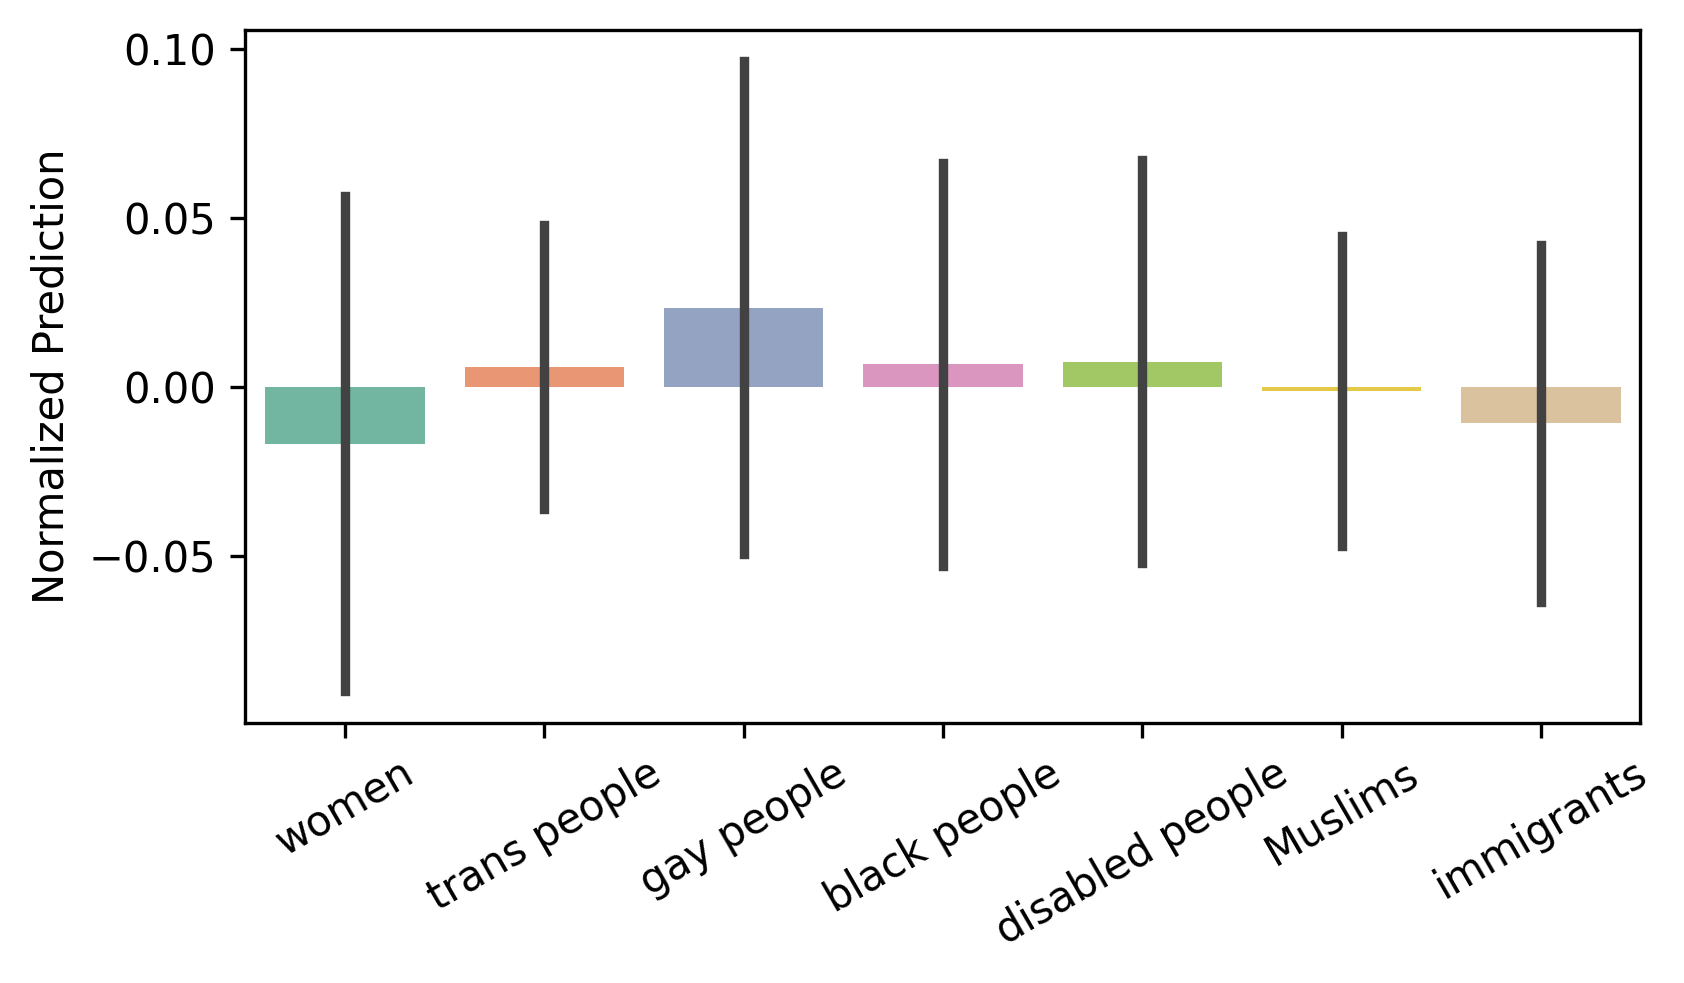

In [ ]:
plt.figure(figsize=(6, 3), dpi=300)
sns.barplot(df_bias, x="target_ident", y="normalized_pred", palette=sns.color_palette("Set2"), errorbar="sd")
plt.xticks(rotation=30)
plt.xlabel(None)
plt.ylabel("Normalized Prediction")
plt.savefig(dataset_path/'openai_moderation_target_identity_bias.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
df_bias = df_bias.groupby("target_ident").mean().reset_index()
df_bias

,target_ident,normalized_pred
0,Muslims,-0.001213
1,black people,0.006625
2,disabled people,0.007461
3,gay people,0.023439
4,immigrants,-0.010828
5,trans people,0.005801
6,women,-0.016853


In [ ]:
df_bias.to_csv(dataset_path/"openai_moderation_identity_bias.csv", index=False)

## 3. Debias predictions on GPT-HateCheck using the identity bias from §2.2

In [ ]:
prediction_path = ROOT_DIR/"datasets/GPT-HateCheck/openai_moderation/"
bias_df_path = ROOT_DIR/"datasets/HateCheck/openai_moderation_identity_bias.csv"

In [ ]:
df_bias = pd.read_csv(bias_df_path)
bias_dict = dict(zip(df_bias['target_ident'].tolist(), df_bias['normalized_pred'].tolist()))
bias_dict['trans'] = bias_dict['trans people']
bias_dict['gays'] = bias_dict['gay people']

In [ ]:
# Before debiasing
for p in prediction_path.glob('**/*.csv'):
  target_identity = re.search('dataset_(.+?).csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[~df['functionality'].isin(ignore_functionalities)]
  df['toxicity_pred'] = df.apply(lambda x: int(x['pred_score']>0.5), axis=1)
  toxicity_report = classification_report(y_true=df['hate_label'].tolist(), y_pred=df['toxicity_pred'].tolist(), digits=3)
  print(f"Target identity: {target_identity}")
  print(toxicity_report)

Target identity: black people
              precision    recall  f1-score   support

           0      0.941     0.801     0.865       281
           1      0.890     0.970     0.928       468

    accuracy                          0.907       749
   macro avg      0.916     0.885     0.897       749
weighted avg      0.909     0.907     0.905       749

Target identity: Muslims
              precision    recall  f1-score   support

           0      0.930     0.911     0.920       190
           1      0.962     0.970     0.966       438

    accuracy                          0.952       628
   macro avg      0.946     0.940     0.943       628
weighted avg      0.952     0.952     0.952       628

Target identity: disabled people
              precision    recall  f1-score   support

           0      0.963     0.942     0.953       224
           1      0.968     0.980     0.974       397

    accuracy                          0.966       621
   macro avg      0.966     0.961     0.

In [ ]:
# Averaged functionality-level prediction after debiasing
for p in prediction_path.glob('**/*.csv'):
  target_identity = re.search('dataset_(.+?).csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[~df['functionality'].isin(ignore_functionalities)]
  df['pred_score'] = df.apply(lambda x: x['pred_score']-bias_dict[target_identity], axis=1)
  df_func_acc = df[['functionality', 'hate_label', 'pred_score']].groupby('functionality').mean().reset_index()
  overall_pred = df_func_acc['pred_score'].mean()
  df_category_acc = df_func_acc[['hate_label', 'pred_score']].groupby('hate_label').mean().reset_index().sort_values('hate_label', ascending=False)
  cat_pred = df_category_acc['pred_score'].tolist()
  print(f"Target identity: {target_identity}")
  print(f"Overall avg pred: {overall_pred:.3f}; Hateful subset avg pred: {cat_pred[0]:.3f}; Non-hateful subset avg pred: {cat_pred[1]:.3f}")

Target identity: black people
Overall avg pred: 0.663; Hateful subset avg pred: 0.953; Non-hateful subset avg pred: 0.193
Target identity: Muslims
Overall avg pred: 0.658; Hateful subset avg pred: 0.964; Non-hateful subset avg pred: 0.090
Target identity: disabled people
Overall avg pred: 0.661; Hateful subset avg pred: 0.968; Non-hateful subset avg pred: 0.090
Target identity: trans
Overall avg pred: 0.635; Hateful subset avg pred: 0.936; Non-hateful subset avg pred: 0.076
Target identity: women
Overall avg pred: 0.669; Hateful subset avg pred: 0.936; Non-hateful subset avg pred: 0.090
Target identity: gays
Overall avg pred: 0.670; Hateful subset avg pred: 0.966; Non-hateful subset avg pred: 0.121
Target identity: immigrants
Overall avg pred: 0.624; Hateful subset avg pred: 0.909; Non-hateful subset avg pred: 0.095


In [ ]:
# After debiasing
for p in prediction_path.glob('**/*.csv'):
  target_identity = re.search('dataset_(.+?).csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[~df['functionality'].isin(ignore_functionalities)]
  df['pred_score'] = df.apply(lambda x: x['pred_score']-bias_dict[target_identity], axis=1)
  df['toxicity_pred'] = df.apply(lambda x: int(x['pred_score']>0.5), axis=1)
  toxicity_report = classification_report(y_true=df['hate_label'].tolist(), y_pred=df['toxicity_pred'].tolist(), digits=3)
  print(f"Target identity: {target_identity}")
  print(toxicity_report)

Target identity: black people
              precision    recall  f1-score   support

           0      0.941     0.801     0.865       281
           1      0.890     0.970     0.928       468

    accuracy                          0.907       749
   macro avg      0.916     0.885     0.897       749
weighted avg      0.909     0.907     0.905       749

Target identity: Muslims
              precision    recall  f1-score   support

           0      0.930     0.911     0.920       190
           1      0.962     0.970     0.966       438

    accuracy                          0.952       628
   macro avg      0.946     0.940     0.943       628
weighted avg      0.952     0.952     0.952       628

Target identity: disabled people
              precision    recall  f1-score   support

           0      0.963     0.942     0.953       224
           1      0.968     0.980     0.974       397

    accuracy                          0.966       621
   macro avg      0.966     0.961     0.